In [1]:
# load a MRI image and print its shape
import nibabel as nib

path = "MR_00008.nii.gz"
img = nib.load(path)
data = img.get_fdata()
print(data.shape)

(256, 256, 140)


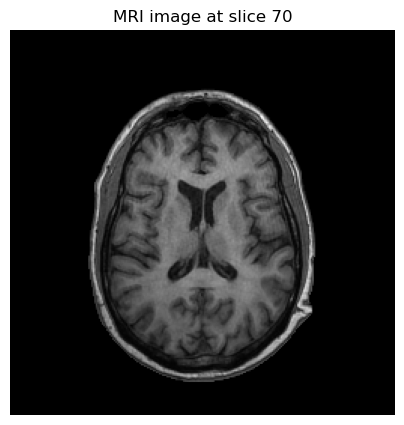

In [2]:
# plot the central slice of the image
import matplotlib.pyplot as plt
import numpy as np

slice_idx = int(data.shape[2] / 2)
plt.figure(figsize=(5, 5))
slice = data[:, :, slice_idx]
slice = np.rot90(slice)
plt.imshow(slice, cmap="gray")
plt.axis('off')
plt.title("MRI image at slice {}".format(slice_idx))
plt.show()

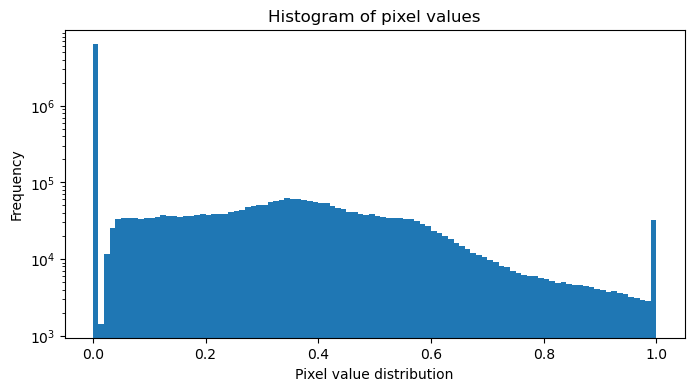

In [3]:
# now we need to normalize the pixel values from 0 to 3000 to 0 to 1

data = np.clip(data, 0, 3000)
data = data / 3000

# plot a histogram of the pixel values and use log scale for the y-axis
plt.figure(figsize=(8, 4))
plt.hist(data.flatten(), bins=100)
plt.xlabel("Pixel value distribution")
plt.ylabel("Frequency")
plt.title("Histogram of pixel values")
plt.yscale("log")
plt.show()

In [4]:
def plot_img(img):
    plt.figure(figsize=(5, 5))
    img = np.rot90(img)
    plt.imshow(img, cmap="gray")
    plt.axis('off')
    plt.title("MRI image")
    plt.show()

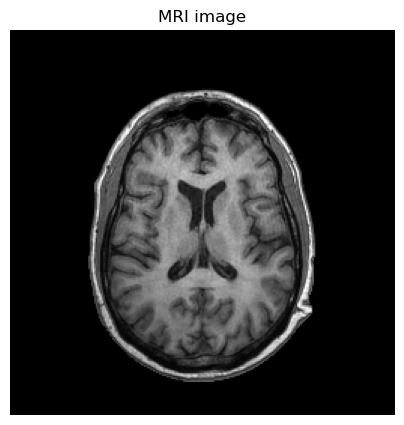

In [5]:
plot_img(data[:, :, slice_idx])

In [6]:
# we have three yita and the time t

yita_1 = 0.1
yita_2 = 0.2
yita_3 = 0.3

t = 300

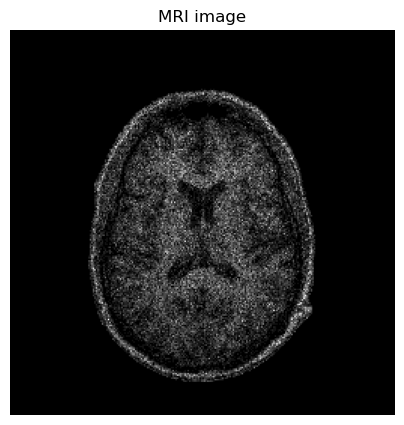

In [7]:
# Now we need to simulate the PVC process
# 1. use the MRI image as the mu_map to generate a poission distribution img taking a constant yita_1 and time t
# we will use the poisson.rvs because the documentation of poisson.rvs is as following:
# poisson.rvs(mu, size=1, random_state=None)
# mu is the mean of the distribution
# size is the output shape
# random_state is the seed for the random number generator
# so we can use the MRI image as the mu_map and the size is the shape of the MRI image


from scipy.stats import poisson
import numpy as np

yita_1 = 0.025
mu_map = data * yita_1 * t

poisson_img = np.random.poisson(mu_map)
plot_img(poisson_img[:, :, slice_idx])

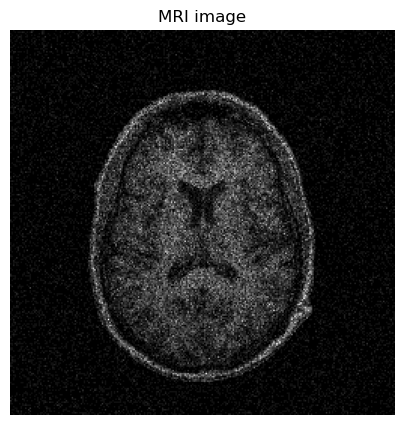

In [8]:
# 2, adding a uniform poisson noise to the image, the mu is depend on the yita_2 and the time t

yita_2 = 0.001

mu_map = yita_2 * t
poisson_noise = np.random.poisson(mu_map, data.shape)
noisy_img = poisson_img + poisson_noise
plot_img(noisy_img[:, :, slice_idx])

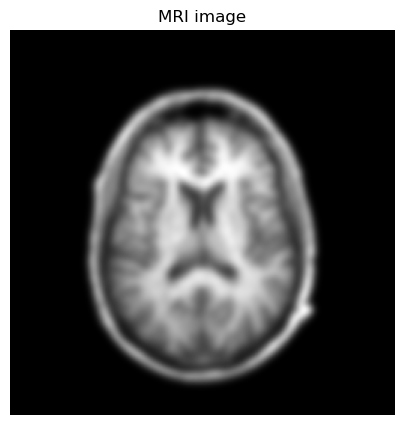

In [38]:
# 3, simulate the Partial Volume Effect using nibabel.processing.smooth_image , the fwhm is dependent on yita_3 and t
# the smooth_image function takes the nib.Nifti1Image as the input and the fwhm is the full width at half maximum

yita_3 = 2e-2
fwhm = yita_3 * t
from nibabel.processing import smooth_image
pvc_img = smooth_image(nib.Nifti1Image(noisy_img, img.affine, img.header), fwhm=fwhm).get_fdata()
plot_img(pvc_img[:, :, slice_idx])

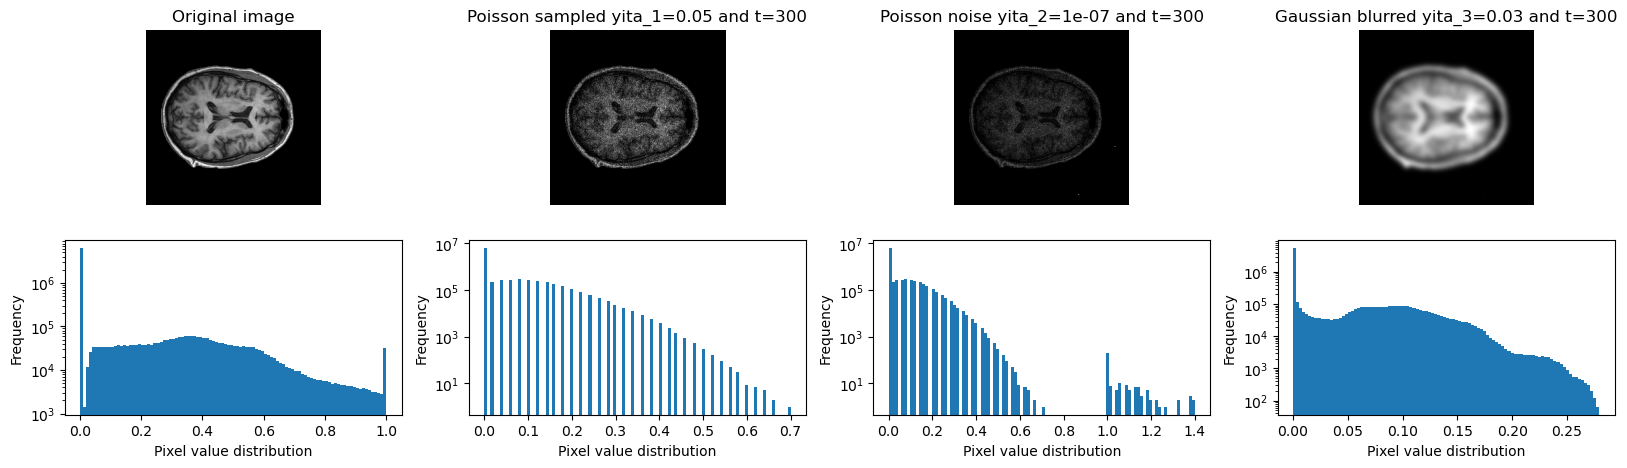

In [51]:
# plot the original image, step 1, step2, step3 image in 2 row and 4 columns
from nibabel.processing import smooth_image


yita_1, yita_2, yita_3 = 5e-2, 1e-7, 3e-2
t = 300

mu_map = data * yita_1 * t
poisson_img = np.random.poisson(mu_map) / 50
poisson_noise = np.random.poisson(yita_2 * t, data.shape)
noisy_img = poisson_img + poisson_noise
fwhm = yita_3 * t
pvc_img = smooth_image(nib.Nifti1Image(noisy_img, img.affine, img.header), fwhm=fwhm).get_fdata()

plt.figure(figsize=(20, 5))
plt.subplot(2, 4, 1)
plt.imshow(data[:, :, slice_idx], cmap="gray")
plt.axis('off')
plt.title("Original image")

plt.subplot(2, 4, 2)
plt.imshow(poisson_img[:, :, slice_idx], cmap="gray")
plt.axis('off')
plt.title("Poisson sampled yita_1={}".format(yita_1) + " and t={}".format(t))

plt.subplot(2, 4, 3)
plt.imshow(noisy_img[:, :, slice_idx], cmap="gray")
plt.axis('off')
plt.title("Poisson noise yita_2={}".format(yita_2) + " and t={}".format(t))

plt.subplot(2, 4, 4)
plt.imshow(pvc_img[:, :, slice_idx], cmap="gray")
plt.axis('off')
plt.title("Gaussian blurred yita_3={}".format(yita_3) + " and t={}".format(t))

# the second row is the pixel value distribution of the original image, step 1, step2, step3 image

plt.subplot(2, 4, 5)
plt.hist(data.flatten(), bins=100)
plt.xlabel("Pixel value distribution")
plt.ylabel("Frequency")
# plt.title("Original image")
plt.yscale("log")

plt.subplot(2, 4, 6)
plt.hist(poisson_img.flatten(), bins=100)
plt.xlabel("Pixel value distribution")
plt.ylabel("Frequency")
# plt.title("Poisson sampled yita_1={}".format(yita_1) + " and t={}".format(t))
plt.yscale("log")

plt.subplot(2, 4, 7)
plt.hist(noisy_img.flatten(), bins=100)
plt.xlabel("Pixel value distribution")
plt.ylabel("Frequency")
# plt.title("Poisson noise yita_2={}".format(yita_2) + " and t={}".format(t))
plt.yscale("log")

plt.subplot(2, 4, 8)
plt.hist(pvc_img.flatten(), bins=100)
plt.xlabel("Pixel value distribution")
plt.ylabel("Frequency")
# plt.title("Gaussian blurred yita_3={}".format(yita_3) + " and t={}".format(t))
plt.yscale("log")




In [61]:
#now merge the code into a function

def simulate_pvc(img, yita_1, yita_2, yita_3, r):

    data = img.get_fdata()
    data = np.clip(data, 0, 3000)
    data = data / 3000 
    mu_map = data * yita_1 * r
    poisson_img = np.random.poisson(mu_map) / 50
    poisson_noise = np.random.poisson(yita_2 * r, data.shape)
    noisy_img = poisson_img + poisson_noise
    fwhm = yita_3 * r
    pvc_img = smooth_image(nib.Nifti1Image(noisy_img, img.affine, img.header), fwhm=fwhm).get_fdata()

    return pvc_img

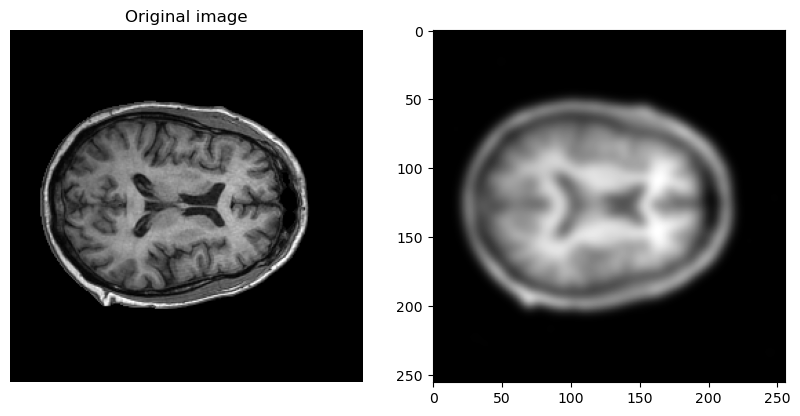

In [62]:
# now we need to have a test to see if the function works

yita_1, yita_2, yita_3 = 5e-2, 1e-7, 3e-2
r = 300
pvc_img = simulate_pvc(img, yita_1, yita_2, yita_3, r)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(data[:, :, slice_idx], cmap="gray")
plt.axis('off')
plt.title("Original image")

plt.subplot(1, 2, 2)
plt.imshow(pvc_img[:, :, slice_idx], cmap="gray")

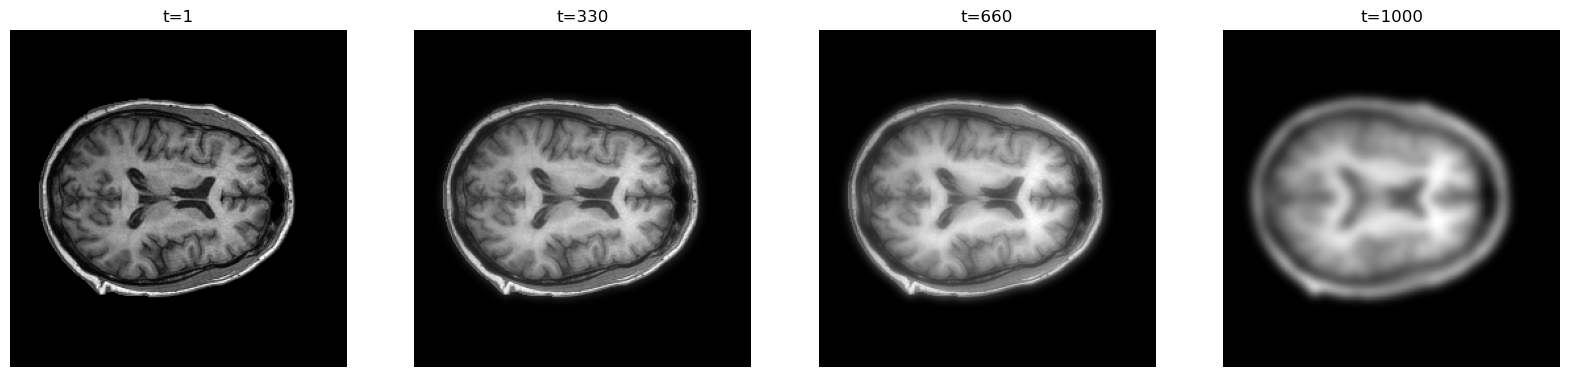

In [66]:
# now we have a ratio t between 1 to 1000 to define the level of fusion between the two images
# t=1 means the image is 100% from the original image, t=1000 means the image is 100% from the simulated image

# we need to have a function to generate the image with different t
# we modify the curve of t to be a cubic root function

yita_1, yita_2, yita_3, r = 5e-2, 1e-7, 3e-2, 300
ori_img = img.get_fdata()
ori_img = np.clip(ori_img, 0, 3000)
ori_img = ori_img / 3000
pvc_img = simulate_pvc(img, yita_1, yita_2, yita_3, r)

def generate_fusion_img(ori_img, pvc_img, t, max_t=1000):
    shifted_t = (t - 1) / max_t
    shifted_t = shifted_t ** (1/3)
    fusion_img = ori_img * (1-shifted_t) + pvc_img * shifted_t
    return fusion_img

# we will generate from t=1, 330, 660, 1000 and plot the image

t_list = [1, 330, 660, 1000]
plt.figure(figsize=(20, 5))
for i, t in enumerate(t_list):
    fusion_img = generate_fusion_img(ori_img, pvc_img, t)
    plt.subplot(1, 4, i + 1)
    plt.imshow(fusion_img[:, :, slice_idx], cmap="gray")
    plt.axis('off')
    plt.title("t={}".format(t))

